In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [4]:
df = load_pkl('../../data/feat_engin/lgbm/data_15min_1hour_1day.pkl')

In [6]:
df.shape

(2362117, 1712)

In [7]:
df.head()

,time,close,volume,ticker,tmos_close,index_1hour,index_1day,result,delta_time,income_rate,...,tmos_close_1day_w10_min/tmos_close_1day_w10_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w30_min/close_1day_w30_max,tmos_close_1day_w30_min/tmos_close_1day_w30_max,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max
0,2022-05-04 10:00:00,31.520000,165423.0,AFLT,4.30,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-04 10:15:00,31.920000,99825.0,AFLT,4.32,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-04 10:30:00,32.400002,171391.0,AFLT,4.29,NaN,NaN,WIN,0 days 00:45:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04 10:45:00,32.099998,66741.0,AFLT,4.27,0.0,NaN,WIN,0 days 00:30:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-04 11:00:00,31.940001,42552.0,AFLT,4.25,0.0,NaN,WIN,0 days 00:15:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['result'].value_counts(normalize=True)

result
DNF     0.487526
LOSE    0.407979
WIN     0.104495
Name: proportion, dtype: float64

In [9]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.994000
0.01    0.994000
0.10    0.994000
0.20    0.994000
0.30    0.994000
0.40    0.994000
0.50    0.997773
0.60    0.999747
0.70    1.001901
0.80    1.005115
0.90    1.014000
0.99    1.014000
1.00    1.014000
Name: income_rate, dtype: float64

In [10]:
#распределение времени в часах
(df['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       4.0
0.50       4.0
0.60       4.0
0.70       4.0
0.80      13.0
0.90      16.0
0.99      65.0
1.00    6734.0
Name: delta_time, dtype: float64

## CHANGE TARGET

In [14]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    # #макс выигрыш и потери
    # if percent_first < percent_second:  
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    # else:
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [16]:
inds = np.arange(df.shape[0])
inds.shape

(2362117,)

In [25]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=0.995, percent_second=1.015, points_to_wait=4*4*1)

100%|█████████████████████████████████████████████████████████████| 2362117/2362117 [09:28<00:00, 4157.43it/s]


In [28]:
dump_pkl(df_result, '../../data/feat_engin/lgbm/df_result_-0.5_+1.5_4hour.pkl')

In [30]:
df_result = load_pkl('../../data/feat_engin/lgbm/df_result_-0.5_+1.5_4hour.pkl')
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,WIN,AFLT,0 days 00:30:00,1.014000,32.400002,2
1,1,2022-05-04 10:15:00,31.920000,WIN,AFLT,0 days 00:15:00,1.014000,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,LOSE,AFLT,0 days 00:15:00,0.994000,32.099998,3
3,3,2022-05-04 10:45:00,32.099998,LOSE,AFLT,0 days 00:30:00,0.994000,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,LOSE,AFLT,0 days 00:15:00,0.994000,31.299999,5
...,...,...,...,...,...,...,...,...,...
2362112,2362112,2025-02-17 22:45:00,396.179993,DNF,BSPB,0 days 01:00:00,1.002483,397.559998,2362116
2362113,2362113,2025-02-17 23:00:00,397.089996,DNF,BSPB,0 days 00:45:00,1.000184,397.559998,2362116
2362114,2362114,2025-02-17 23:15:00,397.519989,DNF,BSPB,0 days 00:30:00,0.999101,397.559998,2362116
2362115,2362115,2025-02-17 23:30:00,396.480011,DNF,BSPB,0 days 00:15:00,1.001724,397.559998,2362116


In [27]:
df_result['result'].value_counts(normalize=True)

result
DNF     0.477289
LOSE    0.414780
WIN     0.107932
Name: proportion, dtype: float64

In [29]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.708497
0.01    0.979935
0.10    0.990452
0.20    0.992352
0.30    0.993307
0.40    0.993923
0.50    0.997547
0.60    0.999548
0.70    1.001694
0.80    1.004965
0.90    1.014290
0.99    1.028237
1.00    1.515082
Name: income_rate, dtype: float64

In [31]:
#распределение времени в часах
(df_result['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       4.0
0.50       4.0
0.60       4.0
0.70       4.0
0.80      13.0
0.90      16.0
0.99      65.0
1.00    6734.0
Name: delta_time, dtype: float64

In [34]:
(df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True)

In [36]:
df_result.head()

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,WIN,AFLT,0 days 00:30:00,1.026919,32.400002,2
1,1,2022-05-04 10:15:00,31.920000,WIN,AFLT,0 days 00:15:00,1.014038,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,LOSE,AFLT,0 days 00:15:00,0.989741,32.099998,3
3,3,2022-05-04 10:45:00,32.099998,LOSE,AFLT,0 days 00:30:00,0.974078,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,LOSE,AFLT,0 days 00:15:00,0.978962,31.299999,5


In [39]:
df[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]

In [42]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3676
cols = ['ticker', 'time', 'close', 'close_1hour', 'close_1day', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask, cols].iloc[i:i+10]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
250910,FEES,2025-02-03 22:00:00,0.07816,0.07820,0.07898,DNF,0 days 14:00:00,0.994138,0.07778,250926
250911,FEES,2025-02-03 22:15:00,0.07828,0.07820,0.07898,LOSE,0 days 12:45:00,0.993124,0.07782,250922
250912,FEES,2025-02-03 22:30:00,0.07830,0.07820,0.07898,LOSE,0 days 12:30:00,0.992870,0.07782,250922
250913,FEES,2025-02-03 22:45:00,0.07824,0.07824,0.07898,LOSE,0 days 12:15:00,0.993632,0.07782,250922
250914,FEES,2025-02-03 23:00:00,0.07816,0.07824,0.07898,LOSE,0 days 13:45:00,0.993115,0.07770,250929
250915,FEES,2025-02-03 23:15:00,0.07812,0.07824,0.07898,LOSE,0 days 13:30:00,0.993624,0.07770,250929
250916,FEES,2025-02-03 23:30:00,0.07804,0.07824,0.07898,LOSE,0 days 13:30:00,0.990799,0.07740,250930
250917,FEES,2025-02-03 23:45:00,0.07802,0.07802,0.07802,LOSE,0 days 13:15:00,0.991053,0.07740,250930
250918,FEES,2025-02-04 10:00:00,0.07810,0.07802,0.07802,LOSE,0 days 02:45:00,0.993878,0.07770,250929
250919,FEES,2025-02-04 10:15:00,0.07824,0.07802,0.07802,LOSE,0 days 00:45:00,0.993632,0.07782,250922


In [44]:
i = 491081
df[cols].iloc[i:i+1]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
491081,SGZH,2024-10-18 14:30:00,1.683,1.674,1.682,DNF,0 days 04:00:00,1.007318,1.697,491097


### 1. train/valid/test/test2 split

In [49]:
df['target'] = (df['result'] == 'WIN').astype(int)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50180/162261981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['result'] == 'WIN').astype(int)


<Axes: xlabel='time'>

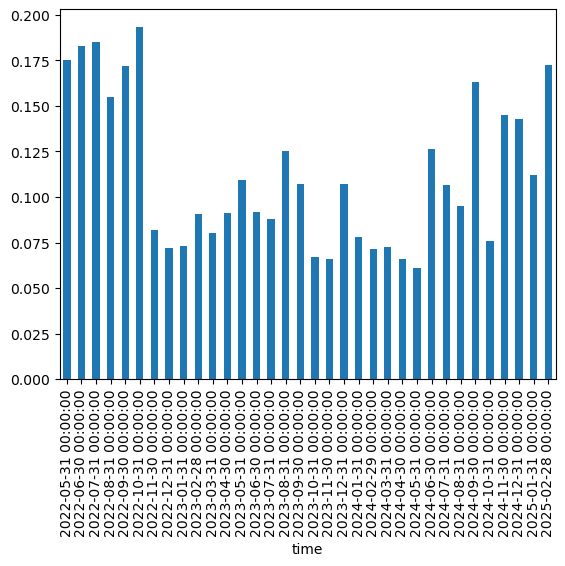

In [51]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

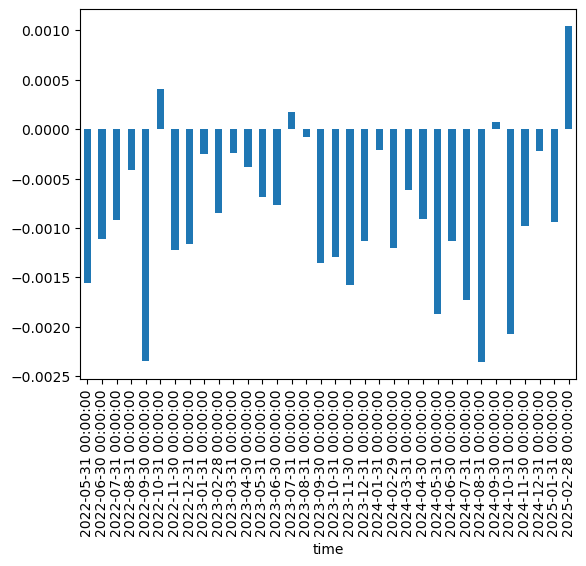

In [52]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [56]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
SBERP    0.051294
LKOH     0.053660
SBER     0.055267
MTSS     0.056237
TATNP    0.057497
IRAO     0.058433
PHOR     0.059455
GAZP     0.061637
ROSN     0.064512
GMKN     0.066719
HYDR     0.066920
TATN     0.067173
SNGSP    0.070686
MOEX     0.071254
TRNFP    0.072309
SIBN     0.075395
NVTK     0.076941
ALRS     0.078327
RTKM     0.078583
MGNT     0.078721
MAGN     0.081652
VTBR     0.085319
CHMF     0.085802
BELU     0.085922
RUAL     0.086720
PLZL     0.087268
NLMK     0.093878
UPRO     0.096192
SNGS     0.097796
POSI     0.098533
VSMO     0.099913
AFLT     0.102767
SGZH     0.103946
ENPG     0.108044
FEES     0.109340
YDEX     0.110666
T        0.111608
AFKS     0.112847
PIKK     0.113184
X5       0.113334
SMLT     0.116117
FLOT     0.118287
MVID     0.119270
BANEP    0.120608
BSPB     0.126424
SELG     0.132208
VKCO     0.132783
TRMK     0.139424
MDMG     0.139966
NMTP     0.141080
RASP     0.142759
WUSH     0.145272
LSRG     0.146954
SPBE     0.151815
FESH     0.154374
RNF

In [58]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
VSMO     0.998381
SPBE     0.998556
SGZH     0.998611
ENPG     0.998817
SMLT     0.998842
RUAL     0.998844
RNFT     0.998876
WUSH     0.998893
HEAD     0.998893
HYDR     0.998897
GMKN     0.998913
MVID     0.998924
VTBR     0.998927
SVAV     0.998932
ALRS     0.998943
SELG     0.998962
VKCO     0.998974
NVTK     0.998983
PHOR     0.999004
MAGN     0.999007
MTSS     0.999012
RTKM     0.999015
SNGS     0.999015
MTLRP    0.999024
GAZP     0.999034
NMTP     0.999039
MGNT     0.999041
TRNFP    0.999048
PIKK     0.999051
FESH     0.999053
NLMK     0.999068
UPRO     0.999070
IRAO     0.999081
POSI     0.999085
TRMK     0.999093
MDMG     0.999094
LKOH     0.999097
RASP     0.999103
ABIO     0.999112
SFIN     0.999119
UNAC     0.999125
ROSN     0.999127
FEES     0.999128
BELU     0.999129
SNGSP    0.999149
SIBN     0.999164
CHMF     0.999190
AFKS     0.999212
TATN     0.999221
PLZL     0.999233
TATNP    0.999238
IRKT     0.999250
FLOT     0.999252
LSRG     0.999255
YDEX     0.999268
SBE

In [62]:
df['time'].max()

Timestamp('2025-02-17 23:45:00')

In [64]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test3 = np.array((pd.Timestamp('2025-01-01') <= df['time']))# & (df['time'] < pd.Timestamp('2025-03-01')))

In [66]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1759268, 162196, 161173, 157454)

In [68]:
mask_test3.sum()

122026

In [71]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 122
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all

mask_test3 &= mask_avbl_all


#мб дату неправильно обрезаю

In [72]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [73]:
mask_test3.sum()

122026

In [76]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

1926950

In [ ]:
for col in tqdm(df.columns):
    assert df.loc[mask_data, col].isnull().sum() == 0, f'Nulls {col}'

In [77]:
df.loc[mask_train, 'ticker'].nunique()

67

In [78]:
#Гуд

In [80]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7504745841874465,
 0.08417239679285918,
 0.0836415060069021,
 0.08171151301279224)

In [82]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.08660995887636425,
 0.1007731386717305,
 0.117184640107214,
 0.14393410138834198)

In [91]:
df.loc[mask_test3, 'target'].mean()

0.1318407552488814

In [94]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.99916923, 0.9979627, 0.99894166, 0.99941176)

In [96]:
df.loc[mask_test3, 'income_rate'].mean()

0.99971783

In [100]:
#проверки

In [102]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [107]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50180/153766446.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_code'] = df['ticker'].astype('category').cat.codes


In [109]:
df['ticker_code'].nunique()

67

In [111]:
df.loc[mask_train, 'ticker_code'].nunique()

67

In [113]:
df.shape

(2362117, 1714)

In [115]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',

 'ticker',

 'index_1hour',
 'index_1day',
    
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',

'time_1hour',
 'close_1hour',
 'volume_1hour',
 'tmos_close_1hour',

'time_1day',
 'close_1day',
 'volume_1day',
 'tmos_close_1day',
    
             'target',
             'y_pred']


features = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [117]:
len(features), len(cat_features)

(1693, 4)

### Get stability features

In [130]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [133]:
#subsample_train

coeff_subsample = 0.2

inds_train = np.argwhere(mask_train).ravel()
inds_train_subsample = np.random.RandomState(seed=42).permutation(inds_train)[:int(len(inds_train)*coeff_subsample)]

mask_train_subsample = np.zeros_like(mask_train).astype(bool)
mask_train_subsample[inds_train_subsample] = True

mask_train_subsample.sum()

289225

In [121]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 4)
    
    return 'mean_income_rate', score, True#is_higher_better

In [138]:



params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
    # "metric": "auc",
    "metric": "mean_income_rate",    
    "early_stopping" : 10, 
    
    
}

auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

                
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],

           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train_subsample, stab_features], label=df.loc[mask_train_subsample, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)

    D_train.income_rate = df.loc[mask_train_subsample, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
    
    D_train.time = df.loc[mask_train_subsample, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values


    
    model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


    threshold1 = np.quantile(y_pred_valid, q=0.99)
    threshold2 = np.quantile(y_pred_valid, q=0.95)
    
    auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


    auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

    
    auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]

auc_features_cp = auc_features.copy()

 16%|██████████▉                                                           | 266/1693 [04:40<36:16,  1.53s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
 21%|██████████████▉                                                       | 362/1693 [06:26<25:49,  1.16s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
 22%|███████████████▎                                                      | 370/1693 [06:36<27:13,  1.23s/it]/opt/anaconda3/lib/p

In [139]:
dump_pkl(auc_features, 'auc_features__-0.5_+1.5_4hour.pkl')

In [126]:
auc_features = load_pkl('auc_features__-0.5_+1.5_4hour.pkl')

In [145]:
pd.set_option('display.max_columns', 100)
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,close_w1_roc,0.534558,0.529292,0.524066,0.515978,0.001016,-0.000205,0.000256,0.000379,0.001173,0.000266,0.000492,0.000463,0.025693,0.005846,0.010822,0.010190,0.000678,-0.000338,0.000107,0.000273,0.000934,0.000004,0.000293,0.000424,0.020537,0.000082,0.006447,0.009329
1,volume_w1_roc,0.506924,0.502729,0.502941,0.500157,-0.000324,-0.001070,-0.000475,-0.000302,-0.000285,-0.001041,-0.000360,-0.000212,-0.006261,-0.022907,-0.007925,-0.004671,-0.000324,-0.001070,-0.000475,-0.000302,-0.000285,-0.001041,-0.000360,-0.000212,-0.006261,-0.022907,-0.007925,-0.004671
2,tmos_close_w1_roc,0.523412,0.527480,0.509308,0.524253,0.000811,-0.001067,-0.000268,-0.000472,0.000400,-0.000835,0.000184,-0.000911,0.002391,-0.012250,0.002950,-0.015849,0.000089,-0.001439,-0.000397,-0.000098,-0.000274,-0.001650,-0.000853,-0.000753,-0.004735,-0.034696,-0.018766,-0.015789
3,close_w5_norm_std,0.613729,0.590364,0.586508,0.556340,0.000319,-0.000429,0.000255,0.000659,-0.000091,-0.000714,-0.000405,-0.000383,-0.001977,-0.015699,-0.008906,-0.008431,0.000032,-0.000691,0.000029,0.000154,-0.000107,-0.000861,-0.000433,-0.000487,-0.002347,-0.018936,-0.009522,-0.010703
4,close_w5_mean_abs_pct,0.621517,0.598807,0.593710,0.560514,-0.000066,-0.000545,-0.000192,0.000314,-0.000158,-0.000760,-0.000687,-0.000405,-0.003460,-0.016715,-0.015112,-0.008918,-0.000066,-0.000545,-0.000192,0.000314,-0.000158,-0.000760,-0.000687,-0.000405,-0.003460,-0.016715,-0.015112,-0.008918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,close_1day_w60_min/close_1day_w60_max,0.621670,0.612020,0.644446,0.576564,-0.000320,-0.000086,0.000468,-0.000014,-0.000288,-0.000108,0.000193,-0.000076,-0.006198,-0.002380,0.004240,-0.001662,-0.000294,-0.000512,0.000126,0.000143,-0.000265,-0.000729,-0.000177,-0.000085,-0.005813,-0.016045,-0.003892,-0.001880
1689,tmos_close_1day_w60_min/tmos_close_1day_w60_max,0.529627,0.514120,0.596984,0.476181,-0.000212,-0.000218,0.000006,-0.000828,-0.000354,-0.000533,-0.000636,-0.000516,-0.003379,-0.005213,-0.013359,-0.008180,-0.000212,-0.000218,0.000006,-0.000828,-0.000354,-0.000533,-0.000636,-0.000516,-0.003379,-0.005213,-0.013359,-0.008180
1690,close_1day_w120_min/close_1day_w120_max,0.608825,0.608379,0.614687,0.564261,-0.000417,-0.000536,0.000054,0.000042,-0.000390,-0.000711,-0.000104,-0.000104,-0.008532,-0.015637,-0.002293,-0.002286,-0.000417,-0.000536,0.000054,0.000042,-0.000390,-0.000711,-0.000104,-0.000104,-0.008532,-0.015637,-0.002293,-0.002286
1691,tmos_close_1day_w120_min/tmos_close_1day_w120_max,0.531253,0.512732,0.497938,0.498897,-0.000329,-0.001530,-0.000351,-0.000120,-0.000332,-0.001950,-0.000346,-0.000104,-0.005822,-0.014300,-0.007604,-0.002296,-0.000329,-0.001530,-0.000351,-0.000120,-0.000332,-0.001950,-0.000346,-0.000104,-0.005822,-0.014300,-0.007604,-0.002296


#### auc <=0.525

In [149]:
auc_treshold = 0.51

In [151]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

205

In [153]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

565

In [155]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

471

In [157]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

705

In [160]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

837

In [161]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

1014

#### delta_auc > 0.05

In [167]:
auc_delta_treshold  = 0.02

In [169]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

584

In [171]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

632

In [173]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

868

In [176]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

919

In [178]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

1166

#### union criterias

In [184]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

1266

In [186]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

1541

In [189]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(427,
 array(['close_w1_roc', 'close_w5_roc', 'volume_w5_alpha', 'volume_w5_rsi',
        'volume_w5_roc', 'tmos_close_w5_norm_std',
        'tmos_close_w5_mean_abs_pct', 'volume_w10_norm_std',
        'volume_w10_mean_abs_pct', 'volume_w10_alpha', 'volume_w10_rsi',
        'volume_w10_roc', 'tmos_close_w10_norm_std',
        'tmos_close_w10_mean_abs_pct', 'volume_w20_mean_abs_pct',
        'tmos_close_w20_norm_std', 'tmos_close_w20_roc',
        'tmos_close_w30_norm_std', 'tmos_close_w30_alpha',
        'tmos_close_w30_roc', 'close_w30_lvl_1.005-1.01',
        'close_w30_lvl_-0.99-0.995', 'close_w30_lvl_-0.97-0.98',
        'close_w30_lvl_1.03-1.04', 'close_w30_lvl_-0.96-0.97',
        'close_w30_lvl_1.04-1.05', 'close_w30_lvl_-0.95-0.96',
        'close_w30_lvl_1.05-1.07', 'tmos_close_w30_lvl_1-1.005',
        'tmos_close_w30_lvl_1.01-1.015', 'tmos_close_w30_lvl_1.015-1.02',
        'close_w60_mean_abs_pct', 'tmos_close_w60_rsi',
        'tmos_close_w60_roc', 'close_w120_roc', 'tmos_

In [191]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
171,close_1hour_w20_mean_abs_pct,0.677848,0.667989,0.667496,0.616654,0.000201,0.000031,0.000762,0.001256,0.000301,-0.000411,-0.000112,0.000653,0.005735,-0.007232,-0.002291,0.011029,-0.000035,-0.000388,0.001048,0.000838,-0.000031,-0.000847,0.000333,-1.100961e-05,-0.000665,-0.017388,0.007325,-0.000214
186,close_1hour_w30_mean_abs_pct,0.683932,0.666611,0.681256,0.619666,0.000174,0.000128,0.001074,0.000443,-0.000125,-0.000446,-0.000230,0.000381,-0.002258,-0.007201,-0.004262,0.004675,-0.000051,-0.000493,0.001340,0.000692,-0.000169,-0.000503,0.000111,5.547326e-04,-0.003492,-0.009595,0.002434,0.010785
1261,close_1hour_w120_min/close_1hour_w120_max,0.679105,0.665141,0.663198,0.587933,0.000148,0.000052,0.000712,0.000541,-0.000041,-0.000072,0.000383,0.000884,-0.000783,-0.001195,0.007657,0.013116,-0.000003,-0.000071,0.000454,0.000435,-0.000122,-0.000533,-0.000116,5.736947e-07,-0.002615,-0.011731,-0.002556,0.000012
87,close_w60_mean_abs_pct,0.682714,0.664745,0.679955,0.624291,-0.000101,-0.000455,0.000602,0.000585,-0.000264,-0.000575,-0.000061,-0.000261,-0.005756,-0.012646,-0.001338,-0.005749,-0.000101,-0.000455,0.000602,0.000585,-0.000264,-0.000575,-0.000061,-2.612984e-04,-0.005756,-0.012646,-0.001338,-0.005749
233,close_1hour_w120_norm_std,0.656675,0.643125,0.644275,0.578751,-0.000052,-0.000325,0.000347,0.000453,-0.000064,-0.000432,-0.000263,-0.000186,-0.001387,-0.009514,-0.005783,-0.004102,-0.000052,-0.000325,0.000347,0.000453,-0.000064,-0.000432,-0.000263,-1.864766e-04,-0.001387,-0.009514,-0.005783,-0.004102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,volume_w10_ma_low_2std/volume,0.510684,0.510189,0.514468,0.503215,-0.000364,-0.001007,-0.000341,-0.000127,-0.000336,-0.001005,-0.000301,-0.000104,-0.007394,-0.022120,-0.006631,-0.002290,-0.000364,-0.001007,-0.000341,-0.000127,-0.000336,-0.001005,-0.000301,-1.040891e-04,-0.007394,-0.022120,-0.006631,-0.002290
125,tmos_close_w120_lvl_-0.985-0.99,0.523025,0.510135,0.537060,0.545342,-0.000183,-0.000635,0.000121,0.000406,-0.000572,-0.001323,-0.000699,-0.000787,-0.009144,-0.023940,-0.011191,-0.014895,-0.000183,-0.000635,0.000121,0.000406,-0.000572,-0.001323,-0.000699,-7.868619e-04,-0.009144,-0.023940,-0.011191,-0.014895
1029,close_1hour_w5_rsi/close_1hour_w10_rsi,0.513384,0.510119,0.513831,0.512260,-0.000234,-0.000877,-0.000185,0.000078,-0.000170,-0.000830,-0.000084,0.000122,-0.003737,-0.018258,-0.001845,0.002682,-0.000234,-0.000877,-0.000185,0.000078,-0.000170,-0.000830,-0.000084,1.219289e-04,-0.003737,-0.018258,-0.001845,0.002682
12,volume_w5_roc,0.518571,0.510113,0.519502,0.513344,-0.000328,-0.001242,-0.000371,-0.000145,-0.000266,-0.001218,-0.000305,-0.000190,-0.005854,-0.026794,-0.006717,-0.004176,-0.000328,-0.001242,-0.000371,-0.000145,-0.000266,-0.001218,-0.000305,-1.898352e-04,-0.005854,-0.026794,-0.006717,-0.004176


In [194]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(152,
 array(['close_w1_roc', 'volume_w5_alpha', 'volume_w5_rsi',
        'volume_w5_roc', 'tmos_close_w5_norm_std',
        'tmos_close_w5_mean_abs_pct', 'volume_w10_alpha', 'volume_w10_rsi',
        'volume_w10_roc', 'tmos_close_w10_norm_std',
        'tmos_close_w10_mean_abs_pct', 'volume_w20_mean_abs_pct',
        'tmos_close_w20_norm_std', 'tmos_close_w30_norm_std',
        'tmos_close_w30_alpha', 'close_w30_lvl_-0.97-0.98',
        'close_w30_lvl_-0.96-0.97', 'close_w30_lvl_-0.95-0.96',
        'tmos_close_w30_lvl_1-1.005', 'close_1hour_w5_rsi',
        'volume_1hour_w5_roc', 'tmos_close_1hour_w5_norm_std',
        'tmos_close_1hour_w5_alpha', 'close_1hour_w10_alpha',
        'volume_1hour_w10_mean_abs_pct', 'tmos_close_1hour_w10_alpha',
        'close_1hour_w20_alpha', 'volume_1hour_w20_mean_abs_pct',
        'volume_1hour_w20_alpha', 'close_1hour_w30_lvl_1.01-1.02',
        'close_1hour_w30_lvl_-0.98-0.99', 'close_1hour_w120_lvl_1.01-1.02',
        'close_1hour_w120_lvl_1.02-1.

In [196]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1106,tmos_close_1hour_w20_ma/tmos_close_1hour_w120_ma,0.567689,0.581445,0.568648,0.548205,0.002877,0.004236,0.002310,5.053282e-04,-1.792442e-03,0.001882,0.002168,-0.000569,-0.000990,0.008280,0.006503,-0.001456,0.001439,0.001456,0.001048,-0.000180,-0.001118,0.000365,0.001527,-0.000592,-0.001123,0.002851,0.006109,-0.002422
383,close_1day_w120_lvl_1.02-1.03,0.559637,0.570109,0.566642,0.549855,-0.000152,-0.000666,0.000060,1.080036e-04,-1.264574e-04,-0.000920,-0.000348,-0.000079,-0.002782,-0.020229,-0.007662,-0.001737,-0.000152,-0.000666,0.000060,0.000108,-0.000126,-0.000920,-0.000348,-0.000079,-0.002782,-0.020229,-0.007662,-0.001737
247,close_1hour_w120_lvl_1.01-1.02,0.563470,0.570030,0.573287,0.552094,-0.000218,-0.000807,-0.000087,1.266003e-04,-2.947844e-04,-0.001001,-0.000362,-0.000081,-0.006485,-0.022022,-0.007967,-0.001778,-0.000218,-0.000807,-0.000087,0.000127,-0.000295,-0.001001,-0.000362,-0.000081,-0.006485,-0.022022,-0.007967,-0.001778
1549,close_1day_w5_expma/close_1day_w120_expma,0.565087,0.567319,0.577515,0.549544,-0.000203,-0.000759,-0.000051,-5.394220e-05,-3.248431e-04,-0.000910,-0.000300,-0.000124,-0.007130,-0.020010,-0.006603,-0.002720,-0.000203,-0.000759,-0.000051,-0.000054,-0.000325,-0.000910,-0.000300,-0.000124,-0.007130,-0.020010,-0.006603,-0.002720
831,tmos_close_w60_min/tmos_close_w60_max,0.567651,0.563091,0.577665,0.555552,0.000675,0.000342,0.000705,4.774332e-04,4.369348e-04,0.000005,-0.000031,-0.000313,0.001558,0.000050,-0.000200,-0.003200,0.000675,0.000342,0.000705,0.000477,0.000437,0.000005,-0.000031,-0.000313,0.001558,0.000050,-0.000200,-0.003200
335,close_1day_w30_lvl_1.02-1.03,0.544152,0.562890,0.547865,0.544595,-0.000254,-0.000769,-0.000199,1.591444e-04,-2.267619e-04,-0.000924,-0.000311,-0.000018,-0.004989,-0.020330,-0.006837,-0.000392,-0.000254,-0.000769,-0.000199,0.000159,-0.000227,-0.000924,-0.000311,-0.000018,-0.004989,-0.020330,-0.006837,-0.000392
1553,close_1day_w10_expma/close_1day_w120_expma,0.567492,0.562595,0.580457,0.553171,-0.000243,-0.000827,-0.000033,-7.116795e-05,-3.442473e-04,-0.000931,-0.000289,-0.000112,-0.007539,-0.020473,-0.006364,-0.002464,-0.000243,-0.000827,-0.000033,-0.000071,-0.000344,-0.000931,-0.000289,-0.000112,-0.007539,-0.020473,-0.006364,-0.002464
385,close_1day_w120_lvl_1.03-1.04,0.552593,0.559646,0.554250,0.538958,-0.000251,-0.000856,-0.000147,-6.258488e-05,-2.229464e-04,-0.000965,-0.000293,-0.000136,-0.004905,-0.021219,-0.006448,-0.002991,-0.000251,-0.000856,-0.000147,-0.000063,-0.000223,-0.000965,-0.000293,-0.000136,-0.004905,-0.021219,-0.006448,-0.002991
249,close_1hour_w120_lvl_1.02-1.03,0.553119,0.559027,0.558469,0.546290,-0.000328,-0.000906,-0.000167,-6.228685e-05,-2.916175e-04,-0.000957,-0.000230,0.000049,-0.006416,-0.021043,-0.005050,0.001073,-0.000328,-0.000906,-0.000167,-0.000062,-0.000292,-0.000957,-0.000230,0.000049,-0.006416,-0.021043,-0.005050,0.001073
387,close_1day_w120_lvl_1.04-1.05,0.543398,0.556990,0.558869,0.530633,-0.000273,-0.000851,-0.000140,-5.334616e-05,-2.487917e-04,-0.000965,-0.000282,-0.000091,-0.005473,-0.021219,-0.006204,-0.002003,-0.000273,-0.000851,-0.000140,-0.000053,-0.000249,-0.000965,-0.000282,-0.000091,-0.005473,-0.021219,-0.006204,-0.002003


### mask3

#### #1

In [208]:
col = 'mir_month@1'
threshold = 0.05
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir_train = df_auc_features[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc_features[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc_features[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc_features[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(6, 16, 12, 23)

In [210]:
(mask_ir_valid&mask_ir_test&mask_ir_test2).sum(), (mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(6, 2)

In [212]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

6

#### #2

In [216]:
col = 'mir_month@1'
threshold = 0.01
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir2_test = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(710, 610)

In [218]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

432

In [221]:
(mask_ir&mask_ir2).sum()

0

In [225]:
mask_criteria3 = mask_ir#&mask_ir2
features_criteria3 = df_auc_features['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(6,
 array(['close/close_w10_ma', 'close/close_w30_ma',
        'close/close_w10_expma', 'close/close_w30_expma',
        'close_w10_max/close', 'close/close_1hour_w10_expma'], dtype=object))

In [227]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
684,close/close_w30_expma,0.604327,0.578284,0.571898,0.552240,0.001606,0.000140,0.000677,0.000342,0.002735,0.002845,0.002536,0.004043,0.043407,0.062585,0.051997,0.084803,0.001179,-0.000353,0.000457,0.000006,0.002167,0.001899,0.002304,0.002608,0.041258,0.041782,0.050690,0.056037
1111,close/close_1hour_w10_expma,0.587098,0.566509,0.558136,0.547400,0.001207,-0.000256,0.000326,-0.000041,0.002327,0.002314,0.002519,0.003136,0.040560,0.050919,0.052908,0.067387,0.001207,-0.000256,0.000326,-0.000041,0.002327,0.002314,0.002519,0.003136,0.040560,0.050919,0.052908,0.067387
636,close/close_w30_ma,0.589096,0.566343,0.552956,0.535591,0.001519,0.000152,0.000724,0.000291,0.002757,0.002913,0.002659,0.004131,0.044735,0.061231,0.057160,0.084536,0.000866,-0.000624,0.000316,-0.000040,0.001756,0.001452,0.002276,0.002314,0.036424,0.031938,0.050067,0.050908
682,close/close_w10_expma,0.578143,0.565383,0.551527,0.542268,0.002303,0.000332,0.001682,0.001216,0.003244,0.002393,0.002768,0.003348,0.056370,0.052640,0.060888,0.073651,0.000009,-0.000650,-0.000311,0.000074,-0.000228,-0.001000,-0.000776,-0.000593,-0.004996,-0.021995,-0.017079,-0.013040
634,close/close_w10_ma,0.569204,0.557547,0.550017,0.539770,0.002217,0.000131,0.001873,0.001359,0.002963,0.002340,0.002833,0.003085,0.052089,0.051474,0.062322,0.067876,0.000878,-0.000507,0.000430,0.000286,0.001761,0.000755,0.001270,0.001398,0.038566,0.016609,0.027939,0.030764
745,close_w10_max/close,0.567085,0.552864,0.549480,0.522132,0.001888,0.000509,0.002207,0.001454,0.002407,0.003022,0.002403,0.003484,0.040266,0.059092,0.051664,0.074876,0.000762,-0.000424,0.000529,0.000427,0.001258,0.000783,0.000995,0.001372,0.027172,0.017221,0.021888,0.030194


### model

In [234]:
features = features_criteria3.tolist()
#features = ['close/close_w30_expma']
cat_features = [feature for feature in features if feature in cat_features_all]

In [236]:
len(features), len(cat_features)

(6, 0)

In [238]:
'ticker_code' in features

False

In [240]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [242]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [245]:



# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

# def mean_income_rate(y_pred, D_sample):
#     q = 0.99
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     df_sup = pd.DataFrame({'time' : D_sample.time,
#                            'income_rate' : D_sample.income_rate,
#                            'y_pred' : y_pred})
#     #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
#     score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
#     score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
#     score = round(score, 4)
    
#     return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1000,

    
    "num_leaves": 5,
    #"learning_rate": 0.001,
     "feature_fraction": 0.3,
     "bagging_fraction": 0.3,
     "bagging_freq": 1,
     'lambda_l1' : 100,
     'lambda_l2' : 100,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    #"metric": "auc",
     "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's mean_income_rate: 0.066


In [247]:
model.num_trees()

10

In [250]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2742803426.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["y_pred"] = None


(0.6434070998803181, 0.6048110227201933, 0.5959145258390846, 0.569199849231256)

In [253]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.607532
WIN     0.252269
DNF     0.140200
Name: proportion, dtype: float64
1.0003368

Test
result
LOSE    0.534812
WIN     0.261641
DNF     0.203548
Name: proportion, dtype: float64
1.0011744

Test2
result
LOSE    0.522584
WIN     0.280732
DNF     0.196684
Name: proportion, dtype: float64
1.0013648


In [256]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2011514514082176

Valid
result
LOSE    0.607532
WIN     0.252269
DNF     0.140200
Name: proportion, dtype: float64
1.0003368

Test
result
LOSE    0.521627
WIN     0.285991
DNF     0.192382
Name: proportion, dtype: float64
1.0015657

Tetst2
result
LOSE    0.522584
WIN     0.280732
DNF     0.196684
Name: proportion, dtype: float64
1.0013648


In [259]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.00033676624298095703, 0.001565694808959961, 0.0013648271560668945)

In [261]:
#(0.00519963161109227, 0.004548106594387313, 0.005202952029520258)

In [263]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9989779, 0.999654, 0.9998805)

In [265]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0031406714, 0.0030377477, 0.0039696856)

In [267]:
#(0.004938866300974756, 0.006170416911948592, 0.0044445648451688635)

In [269]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06602389234014683, 0.060754953883588314, 0.07514707235142935)

In [271]:
#(0.06822526936695361, 0.06629610728651743, 0.06960640537179712)

In [273]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [275]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(2204, 1549, 1749)

In [277]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 40, 37)

In [279]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG',
       'NMTP', 'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN',
       'TGKN', 'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS',
       'VSMO', 'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN',
       'SNGS', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX',
       'CHMF', 'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT',
       'PIKK', 'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'],
      dtype=object)

In [281]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
UPRO,1.0,1.007040
SIBN,1.0,1.014000
PHOR,2.0,1.006803
SNGSP,3.0,1.007333
ROSN,3.0,0.998469
NLMK,3.0,1.007333
GMKN,4.0,1.001495
NVTK,6.0,1.001644
TATNP,6.0,1.008331


In [284]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close/close_w30_expma', 48.83),
 ('close_w10_max/close', 18.11),
 ('close/close_1hour_w10_expma', 10.46),
 ('close/close_w30_ma', 9.76),
 ('close/close_w10_expma', 7.59),
 ('close/close_w10_ma', 5.25)]

# 3.2 Tuning hyperparams

In [510]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [512]:
len(top_features), len(top_cat_features)

(6, 0)

In [514]:
top_features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [295]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [518]:
#D_train.data

In [297]:
D_train.data.shape

(1446127, 6)

In [299]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [301]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*8*8)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 10,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████████| 768/768 [24:24<00:00,  1.91s/it]


In [302]:
dump_pkl(history, './hst_-0.5_+1.5_4hour.pkl')

In [5173]:
history = load_pkl('./hst_-0.5_+1.5_4hour.pkl')

In [305]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642828,0.601831,0.604062,0.573098,0.001818,0.000462,0.001205,0.001078,0.002228,0.002875,0.001664,0.002351,0.044984,0.061846,0.035775,0.048117,0.001045,-0.000154,0.000716,0.000442,0.001309,0.001190,0.001221,0.001036,0.028273,0.026170,0.026858,0.022253
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",12,0.624520,0.594835,0.593708,0.566168,0.001578,-0.000001,0.000883,0.000358,0.002120,0.002219,0.001986,0.001947,0.044832,0.048824,0.043693,0.041837,0.001107,-0.000167,0.000726,0.000363,0.001488,0.001371,0.001372,0.001344,0.032136,0.030159,0.030182,0.028872
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626674,0.595243,0.594842,0.567469,0.001568,0.000011,0.000855,0.000352,0.002111,0.002228,0.001943,0.002014,0.044649,0.049007,0.042757,0.043287,0.001086,-0.000149,0.000659,0.000397,0.001341,0.001297,0.001263,0.001173,0.028894,0.028533,0.027776,0.025214
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642618,0.602215,0.604165,0.573116,0.001816,0.000462,0.001205,0.001078,0.002225,0.002875,0.001664,0.002351,0.044917,0.061846,0.035775,0.048117,0.001112,-0.000048,0.000661,0.000482,0.001318,0.001354,0.001199,0.001266,0.028341,0.029791,0.026379,0.027208
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.650277,0.609061,0.604311,0.571548,0.002125,0.000098,0.001321,0.000950,0.003508,0.002798,0.002544,0.003683,0.068550,0.061556,0.053415,0.077247,0.001283,-0.000278,0.000774,0.000358,0.001904,0.001339,0.001942,0.001856,0.041122,0.029459,0.042714,0.040831
764,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.650052,0.608623,0.604188,0.571333,0.002126,0.000098,0.001321,0.000950,0.003510,0.002798,0.002544,0.003683,0.068583,0.061556,0.053415,0.077247,0.001260,-0.000284,0.000732,0.000358,0.001782,0.001320,0.001809,0.001645,0.038478,0.029041,0.039788,0.035356
765,"{'boosting_type': 'gbdt', 'objective': 'binary...",40,0.649431,0.608804,0.603635,0.570874,0.002059,0.000033,0.001234,0.000853,0.003516,0.002778,0.002727,0.003524,0.071165,0.061117,0.058629,0.073929,0.001275,-0.000337,0.000775,0.000346,0.001907,0.001209,0.001973,0.001705,0.041279,0.026590,0.043408,0.036640
766,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.646752,0.605981,0.599423,0.567547,0.001376,-0.000296,0.000865,0.000257,0.002461,0.001897,0.002538,0.002551,0.051788,0.041732,0.055830,0.054815,0.001235,-0.000389,0.000775,0.000211,0.002470,0.001610,0.002609,0.002466,0.052599,0.035425,0.057401,0.052998


### threshold delta AUC

In [310]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(115, 15, 0)

In [312]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(14, 0)

In [314]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
397,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
405,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
438,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265
446,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265


In [319]:
#df_hst['params'].iloc[1033]

### threshold income_rate

In [1601]:
col = 'mir_month@1'
threshold = 0.06
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(495, 251, 480)

In [1603]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(240, 197)

In [1605]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



197

In [1607]:
#(mask_ir&mask_auc).sum()

In [1609]:
col = 'mir_day@1'
threshold = 0.003

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(378, 237, 524)

In [1611]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(231, 231)

In [1613]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

231

In [1616]:
(mask_ir&mask2_ir).sum()

173

In [1620]:
# col = 'mir_point@1'
# threshold = 0.003

# # mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# # mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# # mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

# mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
# mask3_ir_test = df_hst[f'{col}_test'] >= threshold
# mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


# mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

In [1622]:
# (mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

In [1624]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

In [1627]:
# (mask_ir&mask2_ir&mask3_ir).sum()

In [1630]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'mir_day@1_valid', ascending=False).iloc[:10]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
141,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
133,"{'boosting_type': 'gbdt', 'objective': 'binary...",19,0.660552,0.619019,0.616073,0.578822,0.002484,0.000758,0.001836,0.001296,0.004033,0.003848,0.003362,0.003461,0.069286,0.073378,0.063875,0.063739,0.000957,-0.000045,0.000408,0.001078,0.000726,0.000841,0.000432,0.000549,0.015754,0.018499,0.009496,0.012070
132,"{'boosting_type': 'gbdt', 'objective': 'binary...",13,0.657334,0.615430,0.614047,0.578545,0.002492,0.000723,0.001822,0.001298,0.004081,0.003830,0.003400,0.003451,0.067848,0.073021,0.064603,0.061791,0.000953,-0.000063,0.000454,0.000925,0.000759,0.000765,0.000467,0.000626,0.016514,0.016826,0.010268,0.013777
323,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.658119,0.615756,0.613767,0.578116,0.002305,0.000698,0.001816,0.001323,0.003856,0.003826,0.003341,0.003497,0.066235,0.072947,0.063472,0.062622,0.000924,-0.000072,0.000363,0.000958,0.000699,0.000743,0.000403,0.000465,0.015164,0.016346,0.008875,0.010224
350,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
358,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
115,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
123,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
317,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.649381,0.608174,0.603421,0.572557,0.002337,0.000733,0.002015,0.001329,0.003703,0.003793,0.003041,0.003508,0.065663,0.072323,0.060829,0.064621,0.001178,-0.000119,0.000655,0.000379,0.001424,0.001118,0.001489,0.000903,0.030691,0.024589,0.032765,0.019869


In [1632]:
df_hst.iloc[[111, 149]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
111,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.652944,0.610673,0.608529,0.576003,0.002316,0.000534,0.001741,0.001280,0.003945,0.003393,0.003930,0.003674,0.069954,0.069660,0.082540,0.073317,0.001126,-0.000135,0.000515,0.000352,0.001299,0.001204,0.001439,0.000930,0.027986,0.026483,0.031652,0.020449
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167


In [1636]:
df_hst['params'].iloc[149]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000002,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# Feature selection

In [1640]:
len(top_features), top_features

(6,
 ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma'])

In [1709]:
top_features = ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma']

In [1711]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1713]:
len(features), len(cat_features)

(6, 0)

In [1715]:
'ticker_code' in features

False

In [1717]:
target = 'target'

In [1719]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1720]:
D_test2.data

,close/close_w10_ma,close/close_w30_ma,close/close_w10_expma,close/close_w30_expma,close_w10_max/close,close/close_1hour_w10_expma
34250,1.004638,1.011641,1.005106,1.008195,1.000000,1.007999
34251,1.002253,1.009579,1.002815,1.006102,1.001658,1.006331
34252,1.004541,1.011769,1.004415,1.008132,1.000000,1.008926
34253,0.997600,1.004561,0.997873,1.001022,1.007032,1.001539
34254,0.995200,1.001970,0.996293,0.998703,1.009460,0.999129
...,...,...,...,...,...,...
2338926,1.001332,1.001260,1.000852,1.001409,1.000190,1.002039
2338927,1.001014,1.001202,1.000697,1.001318,1.000190,1.002039
2338928,0.998173,0.998298,0.998102,0.998409,1.003214,0.998649
2338929,1.000872,1.001328,1.000916,1.001335,1.000190,1.001668


In [1983]:
params = { 'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 8,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.8,
#  'bagging_fraction': 0.5,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

# #111 - num_trees=17
# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 5,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.5,
#  'bagging_fraction': 0.3,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1985]:
model.num_trees()

17

In [1988]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [1989]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [1990]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1995]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [1997]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [1999]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1879, 1288, 1455)

In [2001]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2004]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2006]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2008]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2010]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2013]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2015]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


# Drop weak features

In [2020]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

In [1698]:
#Не использовал

In [1700]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['close/close_w10_ma',
 'close/close_w30_expma',
 'close/close_w10_expma',
 'close/close_w30_ma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [1702]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

0

In [1704]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [ ]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [2022]:
features_fe = features
features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [2024]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2026]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2029]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [2031]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [2033]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [2037]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values

In [2041]:
model = lgbm.train(params,  num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [2042]:
#dump_pkl(model, './model.pkl')

In [2045]:
#model = load_pkl('./model.pkl')

In [2047]:
model.num_trees()

17

In [2050]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [2053]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [2056]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6078107687204396

In [2060]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [2062]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.548298
DNF     0.250230
WIN     0.201472
Name: proportion, dtype: float64
1.0003227


In [2064]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'))

In [2066]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:30:00')

In [2069]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [2071]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2075]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(22, 27)

In [2078]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.551661
DNF     0.232472
WIN     0.215867
Name: proportion, dtype: float64
1.000421


In [2080]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [2082]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:22:30')

In [2085]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold
threshold

0.2591240486482249

In [2088]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2092]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2096]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2100]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0004210472106933594

In [2103]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0019698576

In [2106]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.035311521548363894

In [2110]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2112]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


In [2115]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.007534
AFLT,1.0,0.999853
SVAV,1.0,1.005644
MTSS,1.0,0.994000
LSRG,1.0,1.001535
ALRS,2.0,1.008884
UPRO,2.0,1.006774
UWGN,2.0,1.006500
VTBR,2.0,0.994000


In [2117]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [2121]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [2125]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

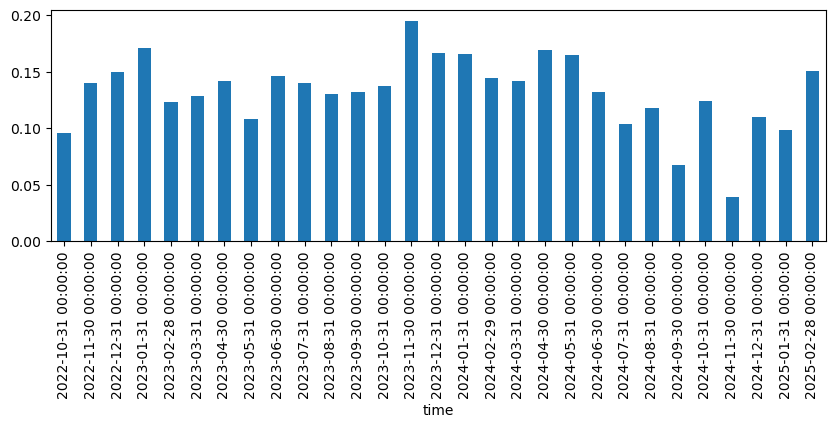

In [2130]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [2134]:
np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

0.2591240486482249

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/3266791285.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

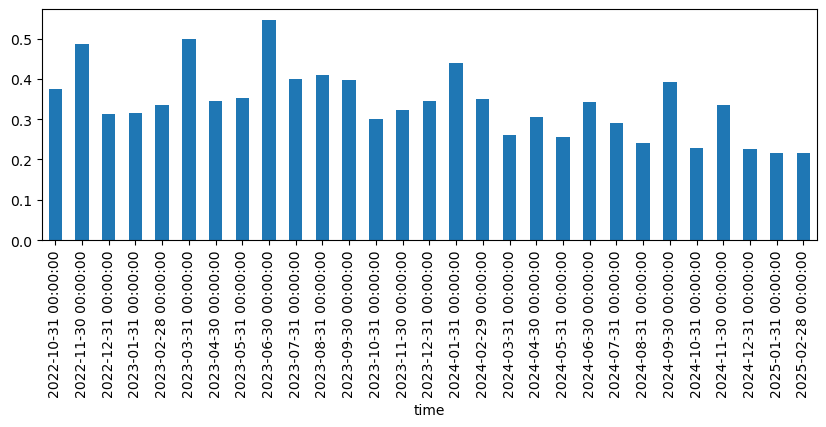

In [2137]:
q = 0.99
col_target = 'target'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2651863704.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


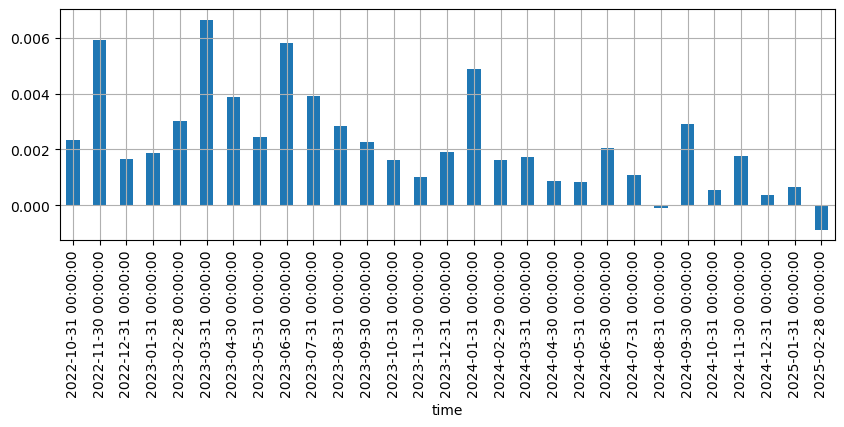

In [2141]:
q = 0.99
col_target = 'income_rate'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

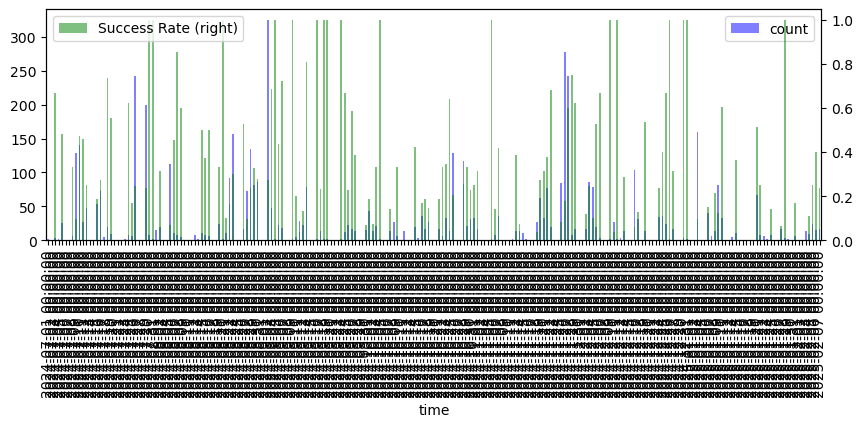

INCOME_RATE


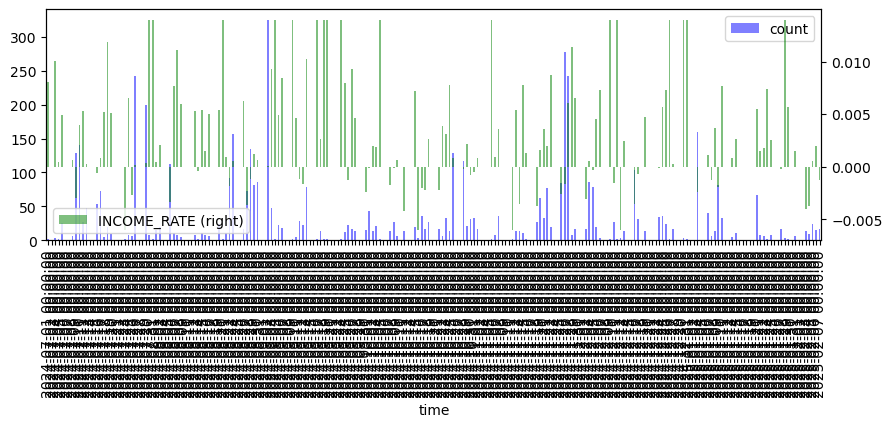

In [2148]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2151]:
#y_test3

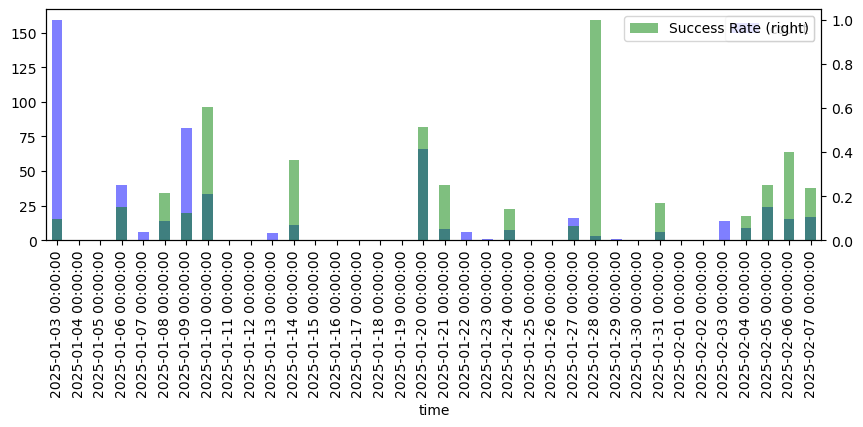

INCOME_RATE


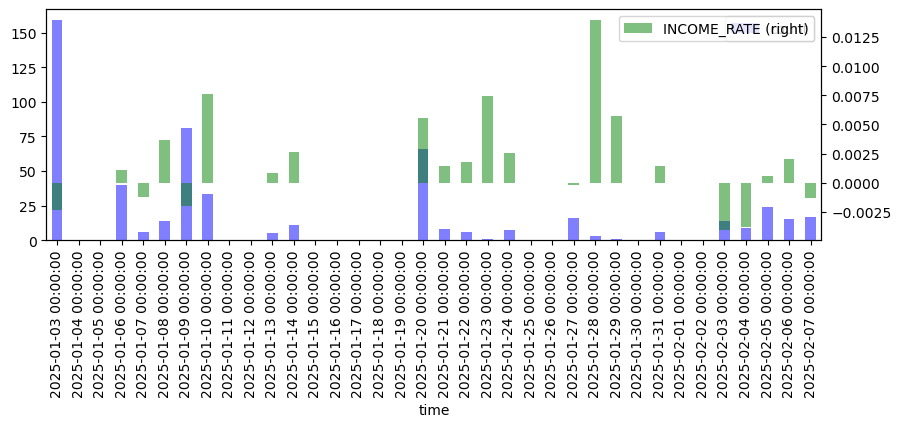

In [2153]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2156]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.0033925232, 0.0039304667, 0.0036743742)

In [2158]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(42, 42, 39)

In [2160]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2162]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2165]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0019698576

In [2167]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

22

In [2169]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.035311521548363894

In [2173]:
mask_data = mask_valid | mask_test | mask_test2

In [2175]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0008289348788377716

In [2178]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0005175173282623291

In [2180]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0017659252598172142

In [2182]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.00015524106147961738

In [2184]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0013936947692524302

#### Points in life

In [2188]:
threshold

0.2591240486482249

In [2190]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1532415291.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20    66
2025-01-21     8
2025-01-22     6
2025-01-23     1
2025-01-24     7
2025-01-25     0
2025-01-26     0
2025-01-27    16
2025-01-28     3
2025-01-29     1
2025-01-30     0
2025-01-31     6
2025-02-01     0
2025-02-02     0
2025-02-03    14
2025-02-04     9
2025-02-05    24
2025-02-06    15
2025-02-07    17
Freq: D, dtype: int64

### Обучить на всем

In [123]:
features_fe = ['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']
cat_features = []
target = 'target'

In [125]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2
#mask_data = mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [128]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [2429]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'num_boost_round': 17}

In [2431]:
model.num_trees()

17

In [2433]:
del params['metric'], params['early_stopping']

KeyError: 'metric'

In [2435]:
params['num_boost_round'] = 17

In [157]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'num_boost_round': 17}

model = lgbm.train(params, train_set=D_data)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [159]:
model.num_trees()

17

In [2466]:
dump_pkl(model, 'model_-0.5_+1.5_4hour.pkl')

In [130]:
model = load_pkl('model_-0.5_+1.5_4hour.pkl')
model.num_trees()

17

In [129]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_45492/1894950171.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["y_pred"] = None


0.6437486059475304

In [131]:
#0.6437486059475304

In [133]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5884482625924234

In [135]:
#0.6092218820291359

In [138]:
THRESHOLD = 0.2591240486482249
THRESHOLD

0.2591240486482249

In [146]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0022094249725341797

In [148]:
#0.0022094249725341797

In [150]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.003565999

In [152]:
#0.003565999

In [154]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.06537664798088372

In [156]:
#0.06537664798088372

In [158]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.002313852310180664

In [160]:
#0.0008516311645507812

In [162]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.003855751

In [164]:
#0.0027811702

In [166]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0771150179207325

In [168]:
#0.05438732811146312

In [170]:
# +-

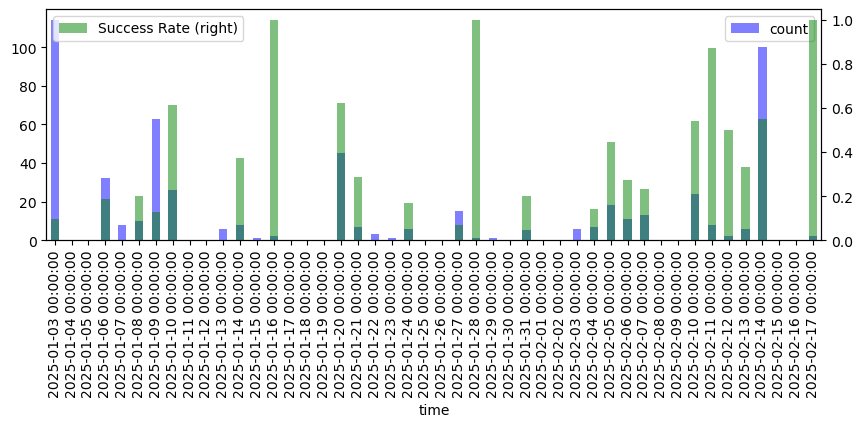

INCOME_RATE


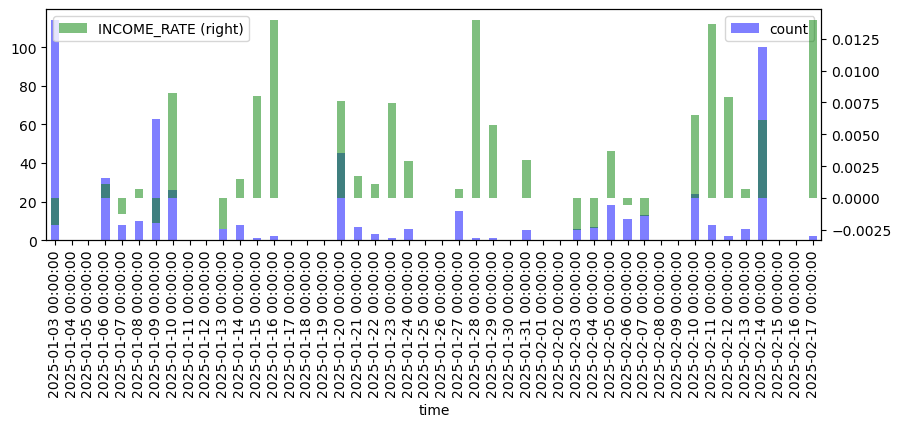

In [172]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [192]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.58),
 ('close/close_w10_expma', 1.86),
 ('close/close_w10_ma', 4.84),
 ('close_w10_max/close', 20.64),
 ('close/close_w30_expma', 23.15),
 ('close/close_1hour_w10_expma', 47.92)]